In [1]:
%load_ext autoreload
%autoreload 2

In [93]:
from src.data.dummy_data import get_engineered_dataloaders, GameDataset, get_fiesta_dataloaders
from run.scripts import train_test, check_memory
from torch.nn import MSELoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam
import torch

from src.ml.model import EvenMoreGradualPlayerModel, PlayerPointsModel
torch.manual_seed(2002);

In [80]:
tdl, vdl, tdl = get_fiesta_dataloaders(name='cactus_flower', train_split=0.8, val_split=0.1, test_split=0.1, batch_size=16)

/Users/samharshe/Documents/Programming/TBN/src/data/dummy_data.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(processed_dataset_path)


In [104]:
cfg_dict = {
    'name': 'fiesta',
    'dataset_name': 'cactus_flower',
    'x_version': 'players',
    'y_version': 'score',
    'batch_size': 16,
    'train_split': 0.8,
    'val_split': 0.1,
    'test_split': 0.1,
    'n_epochs': 10,
    'loss_fn': 'MSELoss',
    'optimizer': 'Adam',
    'scheduler': 'ReduceLROnPlateau',
    'model': 'PlayerScoreModel',
    'd_mod': 32
}

In [106]:
model = PlayerPointsModel(d_in=65, d_mod=cfg_dict['d_mod'])

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
/Users/samharshe/Documents/Programming/TBN/run/scripts.py:310: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1724557174346/work/aten/src/ATen/native/ReduceOps.cpp:1808.)
  f.write(f"  std: {grad.std():.4f}\n")
/Users/samharshe/Documents/Programming/TBN/run/scripts.py:321: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1724557174346/work/aten/src/ATen/native/ReduceOps.cpp:1808.)
  f.write(f"  std: {param.std().item():.4f}\n")


batch_size,▁
train_loss,█▇▇▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_size,1
train_loss,0.00535


final prediction: model(x)
[[0.006074778735637665, 0.21106240153312683, 0.10698794573545456, 0.19417718052864075, 0.01643683761358261, 0.04157187044620514, 0.09421805292367935, 0.5804641842842102, 0.14363598823547363, 0.4998839199542999, 0.013737909495830536, 0.17591530084609985, 0.2793152332305908, 0.004050053656101227, 0.05404914170503616, 0.3675192594528198, 0.00480274111032486, 0.1519593596458435, 0.1395774483680725, 0.03977551311254501, 0.3700190782546997, -0.024095989763736725, 0.004550062119960785, 0.21488726139068604, -0.00014811009168624878, -0.00014811009168624878, -0.00014811009168624878, -0.00014811009168624878]]
actual value: y
[[0.0, 0.2876712381839752, 0.19178082048892975, 0.054794520139694214, 0.08219178020954132, 0.054794520139694214, 0.0, 0.6849315166473389, 0.09589041024446487, 0.3835616409778595, 0.06849315017461777, 0.232876718044281, 0.3835616409778595, 0.027397260069847107, 0.0, 0.19178082048892975, 0.0, 0.2602739632129669, 0.09589041024446487, 0.0, 0.36986300349

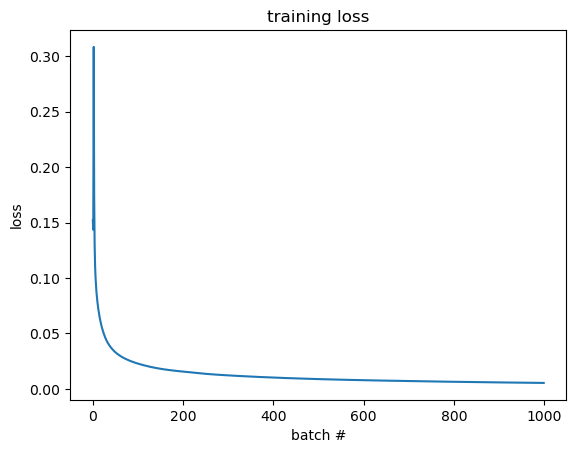

In [107]:
check_memory(model=model, dataloader=tdl, n_epochs=1000, batch_size=1, lr=3e-4)

In [16]:
optimizer = Adam(model.parameters(), lr=3e-4)
loss_fn = MSELoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
n_epochs = cfg_dict['n_epochs']

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


EPOCH 1 OF 10 | electricity | TRAIN MEAN LOSS: 0.010510 | VAL MEAN LOSS: 0.006746
EPOCH 2 OF 10 | electricity | TRAIN MEAN LOSS: 0.006352 | VAL MEAN LOSS: 0.006319
EPOCH 3 OF 10 | electricity | TRAIN MEAN LOSS: 0.005860 | VAL MEAN LOSS: 0.006058
EPOCH 4 OF 10 | electricity | TRAIN MEAN LOSS: 0.005753 | VAL MEAN LOSS: 0.005263
EPOCH 5 OF 10 | electricity | TRAIN MEAN LOSS: 0.005591 | VAL MEAN LOSS: 0.005549
EPOCH 6 OF 10 | electricity | TRAIN MEAN LOSS: 0.005553 | VAL MEAN LOSS: 0.005444
EPOCH 7 OF 10 | electricity | TRAIN MEAN LOSS: 0.005341 | VAL MEAN LOSS: 0.005135
EPOCH 8 OF 10 | electricity | TRAIN MEAN LOSS: 0.005402 | VAL MEAN LOSS: 0.005172
EPOCH 9 OF 10 | electricity | TRAIN MEAN LOSS: 0.005382 | VAL MEAN LOSS: 0.005542
EPOCH 10 OF 10 | electricity | TRAIN MEAN LOSS: 0.005435 | VAL MEAN LOSS: 0.005445


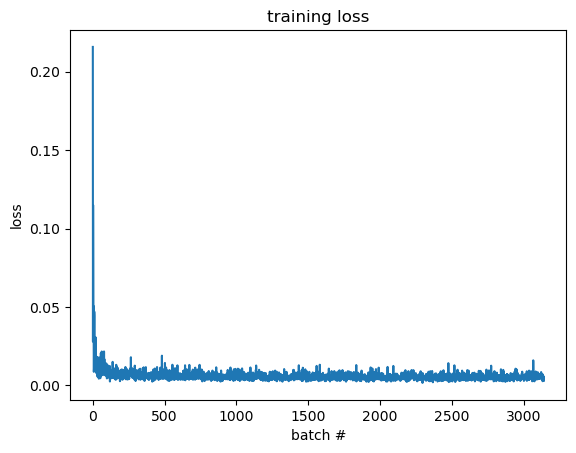

TEST MEAN LOSS: 0.005598
TEST ACCURACY: 0.556439


learning_rate,▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
test_mean_loss,▁
train_mean_loss,█▂▂▂▁▁▁▁▁▁
val_mean_loss,█▆▅▂▃▂▁▁▃▂
learning_rate,0.0003
test_accuracy,0.55644
test_mean_loss,0.0056
train_mean_loss,0.00543
val_mean_loss,0.00544


In [17]:
train_test(model=model, optimizer=optimizer, scheduler=scheduler, loss_fn=loss_fn, train_dataloader=train_score_dataloader, val_dataloader=val_score_dataloader, test_dataloader=test_score_dataloader, cfg_dict=cfg_dict)

In [ ]:
cfg_dict.update({
    'train_split': 0.08,
    'val_split': 0.01,
    'test_split': 0.01
})
train_test(model=model, optimizer=optimizer, scheduler=scheduler, loss_fn=loss_fn, train_dataloader=mini_train_score_dataloader, val_dataloader=mini_val_score_dataloader, test_dataloader=mini_test_score_dataloader, cfg_dict=cfg_dict)
cfg_dict.update({
    'train_split': 0.8,
    'val_split': 0.1,
    'test_split': 0.1
})